# Homework 3: Visualizing Data with Movies

Name: Hetav Vyas

Date: 2/10/2025

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75$^{\circ}$W and $\pm$20$^{\circ}$N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [2]:
# import modules here
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import moviepy.video.io.ImageSequenceClip
import cartopy.feature as cfeature
import cmocean.cm as cm

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [4]:
# define the path to the data folder
data_folder = 'C:\\Users\\Hetav\\OneDrive\\Desktop\\CS185C homework_3'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [6]:
# Define the file path
seaice_file = os.path.join(data_folder, 'Version5', 'Alpha',
                           'latlon_daily', 'SST', 'SST_20150101.nc')

# Read the dataset
ds = xr.open_dataset(seaice_file, decode_times=False)

# Extract longitude, latitude, and sea surface temperature (SST) data
longitude = np.array(ds['LONGITUDE_T'][:])  
latitude = np.array(ds['LATITUDE_T'][:])    
SST = np.array(ds['SST'][:])                

ds.close()

print("Longitude shape:", longitude.shape)
print("Latitude shape:", latitude.shape)
print("SST shape:", SST.shape)


Longitude shape: (1440,)
Latitude shape: (720,)
SST shape: (1, 720, 1440)


Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [8]:
# Define the longitude/latitude bounds
min_lon = -155
max_lon = -75
min_lat = -20
max_lat = 20

min_row = np.argmin(np.abs(latitude - min_lat))
max_row = np.argmin(np.abs(latitude - max_lat))
min_col = np.argmin(np.abs(longitude - min_lon))
max_col = np.argmin(np.abs(longitude - max_lon))

Use the row and column bounds to subset the longitude, latitude, and your variable:

In [10]:
# Subset the data
lon_subset = longitude[min_col:max_col + 1]
lat_subset = latitude[min_row:max_row + 1]  
SST_subset = SST[:, min_row:max_row + 1, min_col:max_col + 1]  

Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

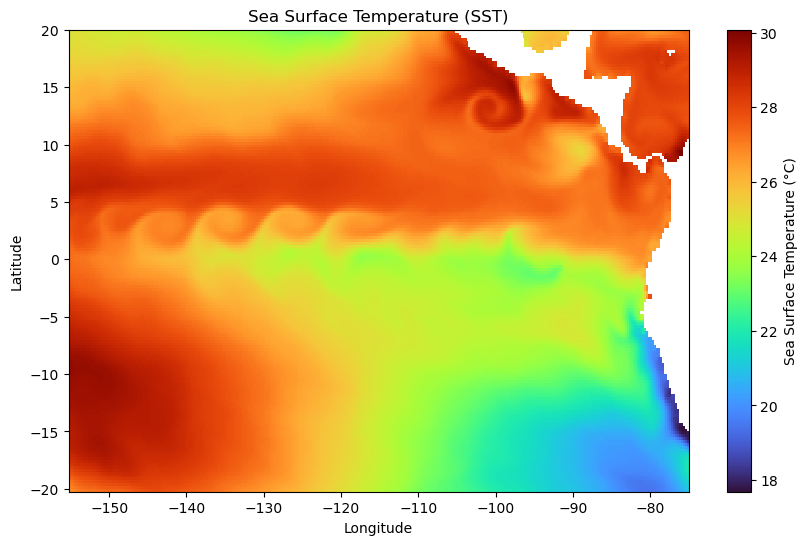

In [12]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(lon_subset, lat_subset, SST_subset[0], cmap='turbo', shading='auto')
plt.colorbar(label='Sea Surface Temperature (°C)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sea Surface Temperature (SST)')
plt.show()

## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [14]:
def plot_frame(SST, file_path):
    
    plt.figure(figsize=(10, 6))
    plt.imshow(SST, cmap='turbo', origin='lower', extent=[-180, 180, -90, 90])
    plt.colorbar(label='Sea Surface Temperature (°C)')
    plt.title('Sea Surface Temperature (SST)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(file_path)  
    plt.close()  

Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [16]:
frames_directory = 'frames'

if not os.path.exists(frames_directory):
    os.makedirs(frames_directory)

file_path = os.path.join(frames_directory, 'SST_20150101.png')

file_list = []

year = 2015
for month in range(1, 13):
    if month in [1, 3, 5, 7, 8, 10, 12]:
        n_days = 31
    elif month in [4, 6, 9, 11]:
        n_days = 30
    else:
        if year % 4 == 0:  
            n_days = 29
        else:
            n_days = 28

    for day in range(1, n_days + 1):
        
        file_name = 'SST_2015{:02d}{:02d}.nc'.format(month, day)
        
        sst_file = os.path.join(data_folder, 'Version5', 'Alpha',
                                'latlon_daily', 'SST', file_name)
        
        ds = xr.open_dataset(sst_file, decode_times=False)
        
        longitude = np.array(ds['LONGITUDE_T'][:])  
        latitude = np.array(ds['LATITUDE_T'][:])    
        SST = np.array(ds['SST'][:])              
        
        ds.close()
        
        SST = SST[0, :, :]  
        
        file_path = os.path.join(frames_directory, 'SST_2015{:02d}{:02d}.png'.format(month, day))
        file_list.append(file_path)
        
        plot_frame(SST, file_path)

## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [18]:
fps = 5  

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(file_list, fps=fps)

clip.write_videofile('SST_2015_Movie.mp4')

MoviePy - Building video SST_2015_Movie.mp4.
MoviePy - Writing video SST_2015_Movie.mp4



MoviePy - Done !
MoviePy - video ready SST_2015_Movie.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: One feature in the movie is the change in sea surface temperature over time. Warmer waters appear to move with ocean currents, showing patterns like the Gulf Stream in the Atlantic. This strong current carries warm water from the tropics to higher latitudes, affecting climate and marine life.